<a href="https://colab.research.google.com/github/tomonari-masada/course2025-sml/blob/main/08_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ロジスティック回帰による糖尿病の予測

* 有名なPima Indians Diabetes Databaseを使う（下リンク先）

  * https://www.kaggle.com/uciml/pima-indians-diabetes-database

* ロジスティック回帰、そして、分類の評価については、下記も参照
  * https://developers.google.com/machine-learning/crash-course/logistic-regression/
  * https://developers.google.com/machine-learning/crash-course/classification/

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    roc_auc_score, RocCurveDisplay,
    average_precision_score, PrecisionRecallDisplay
)
from sklearn.model_selection import StratifiedKFold

%config InlineBackend.figure_format = 'retina'

## データの読み込み

In [2]:
diabetes = pd.read_csv('/content/drive/MyDrive/data/diabetes.csv')

In [3]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
y = diabetes['Outcome']
X = diabetes.drop('Outcome', axis=1)

## 訓練データ、テストデータに分割

**この分割は変えないようにしてください。**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)

In [6]:
X_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000
mean,3.796012,120.973926,69.171779,20.835890,79.903374,32.117638,0.460816,33.291411
std,3.325152,31.248977,19.109787,16.099415,112.705173,7.687094,0.321493,11.801392
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,100.000000,64.000000,0.000000,0.000000,27.300000,0.238000,24.000000
50%,3.000000,117.000000,72.000000,23.000000,37.500000,32.300000,0.364500,29.000000
75%,6.000000,141.000000,80.000000,33.000000,127.250000,36.600000,0.605000,41.000000
max,17.000000,199.000000,122.000000,99.000000,744.000000,59.400000,2.420000,81.000000


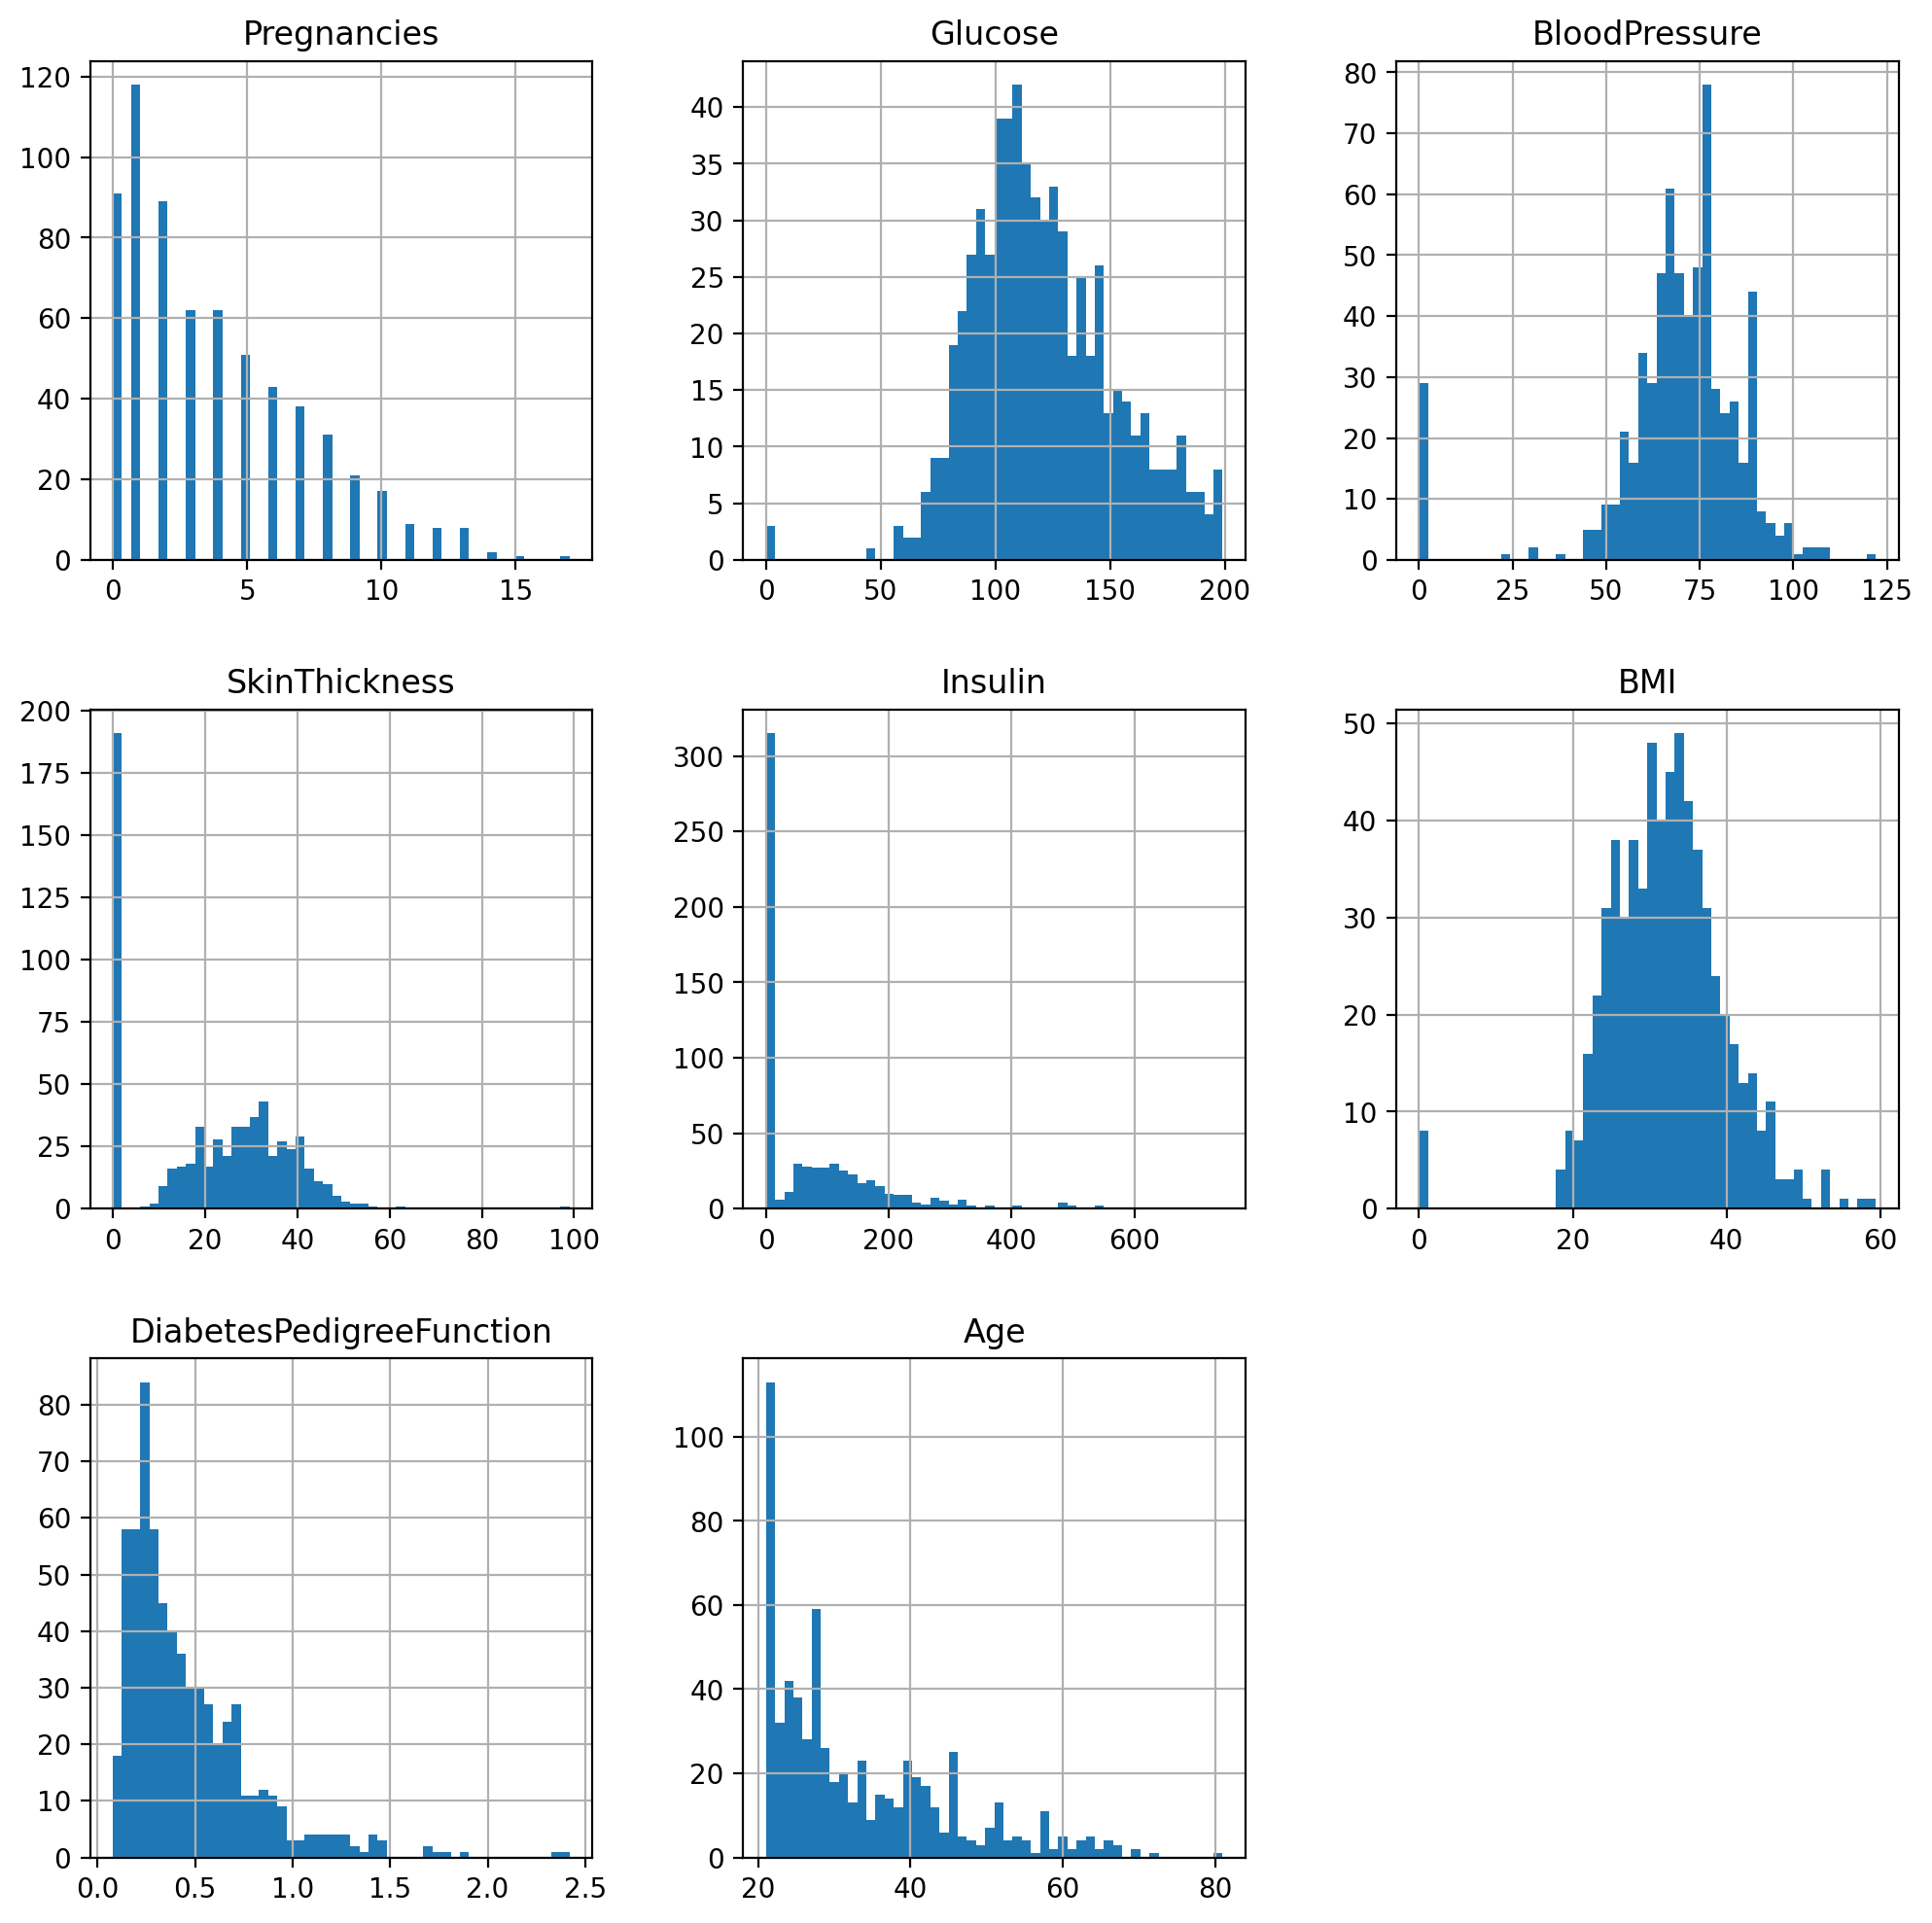

In [7]:
X_train.hist(bins=50, figsize=(12,12));

## ベースライン: デフォルト設定のロジスティック回帰
* 交差検証も何もせずに、単にテストセット以外の部分で、モデルの学習を実行する。

In [8]:
baseline = LogisticRegression(random_state=123)
baseline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=123)

* `max_iter`が小さいとの警告が出ているので、増やして学習しなおし。

In [9]:
baseline = LogisticRegression(max_iter=1000, random_state=123)
baseline.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=123)

* 大丈夫だったので、テストデータでの最終評価値を得る。
 * scoreメソッドを使う。

In [10]:
print(f'test score: {baseline.score(X_test, y_test):.4f}')

test score: 0.8103


* Area under ROC curveも計算してみる。


In [11]:
y_test_pred_proba = baseline.predict_proba(X_test)
print(f'ROC AUC: {roc_auc_score(y_test, y_test_pred_proba[:,1]):.4f}')

ROC AUC: 0.8617


* ROC curveを描いてみる。
 * https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

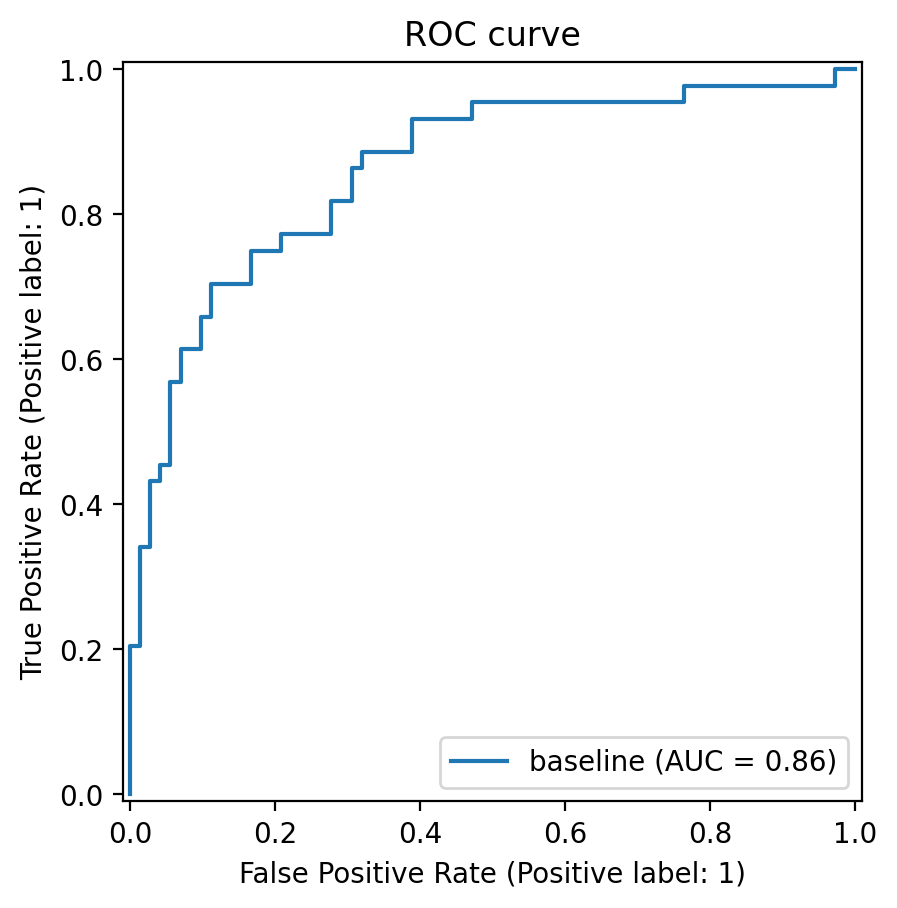

In [14]:
display = RocCurveDisplay.from_estimator(baseline, X_test, y_test, name="baseline")
_ = display.ax_.set_title("ROC curve")

* precision-recall curveを描いてみる。

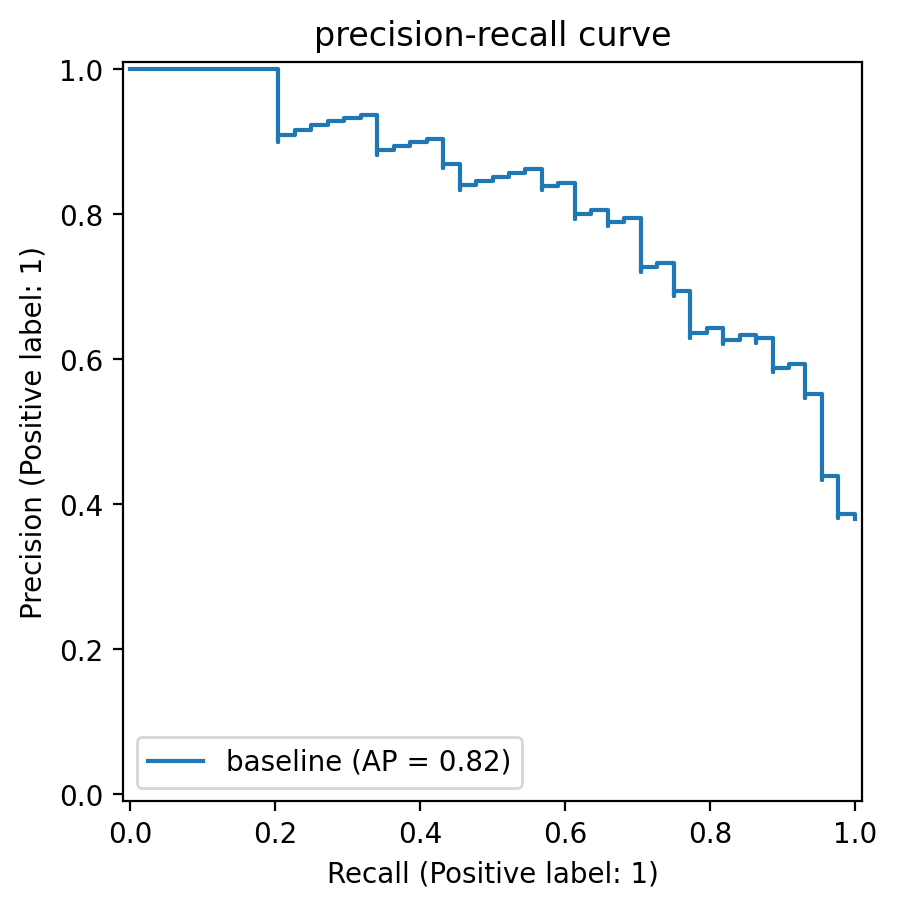

In [15]:
display = PrecisionRecallDisplay.from_estimator(baseline, X_test, y_test, name="baseline")
_ = display.ax_.set_title("precision-recall curve")

In [17]:
average_precision = average_precision_score(y_test, y_test_pred_proba[:,1])
print(f'average precision: {average_precision:.4f}')

average precision: 0.8186


* これをベースラインとみなす。
* これより良い結果を得るべく、試行錯誤する。
* 試行錯誤した結果として辿り着いたモデルで、**最後に一回、テストデータ上での評価**を行う。

---

**以下、訓練データ部分を使って、交差検証によって良いモデルを探す。**

* ここに示すのは一つの試行錯誤の例なので、これに従わなくても全然大丈夫です。
---



## 交差検証しつつ試行錯誤

* 元々の訓練データのコピーを作っておく。

In [23]:
X_train_original = X_train.copy()

### 交差検証の準備

In [24]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

* 交差検証のためのヘルパ関数

In [27]:
def cv(skf, X_train, y_train, preprocess=None, max_iter=1000, **kwargs):

  # キーワード引数として、モデルの設定を指定できるようにしてある。
  for kwarg in kwargs:
    print(f'{kwarg} = {kwargs[kwarg]}')

  # 交差検証のループ
  scores = []
  for train_index, valid_index in skf.split(X_train, y_train):

    cv_X_train = X_train.iloc[train_index]
    cv_y_train = y_train.iloc[train_index]
    cv_X_valid = X_train.iloc[valid_index]
    cv_y_valid = y_train.iloc[valid_index]

    # データの前処理
    #   その都度、関数preprocessを定義してから、この関数cvを呼び出す。
    if preprocess:
      cv_X_train, cv_X_valid = preprocess(cv_X_train, cv_X_valid)

    # ロジスティック回帰の学習
    model = LogisticRegression(**kwargs, max_iter=max_iter)
    model.fit(cv_X_train, cv_y_train)

    # 検証データでの評価
    #score = model.score(cv_X_valid, cv_y_valid)
    score = average_precision_score(cv_y_valid, model.predict_proba(cv_X_valid)[:,1])
    print(f'average precision: {score:.4f}')
    scores.append(score)

  mean_score = np.array(scores).mean()
  print(f'mean average precision: {mean_score:.4f}')
  return mean_score

### デフォルトの設定での評価
* 交差検証で性能評価するとどうなるかを確認している。

In [28]:
cv(skf, X_train, y_train);

average precision: 0.7492
average precision: 0.8637
average precision: 0.6598
average precision: 0.5830
average precision: 0.7689
average precision: 0.8337
average precision: 0.5805
average precision: 0.6817
average precision: 0.7466
average precision: 0.6964
mean average precision: 0.7163


### BloodPressureへの対応

* まず、属性「BloodPressure」について、ヒストグラムを描いてよくよく眺める。


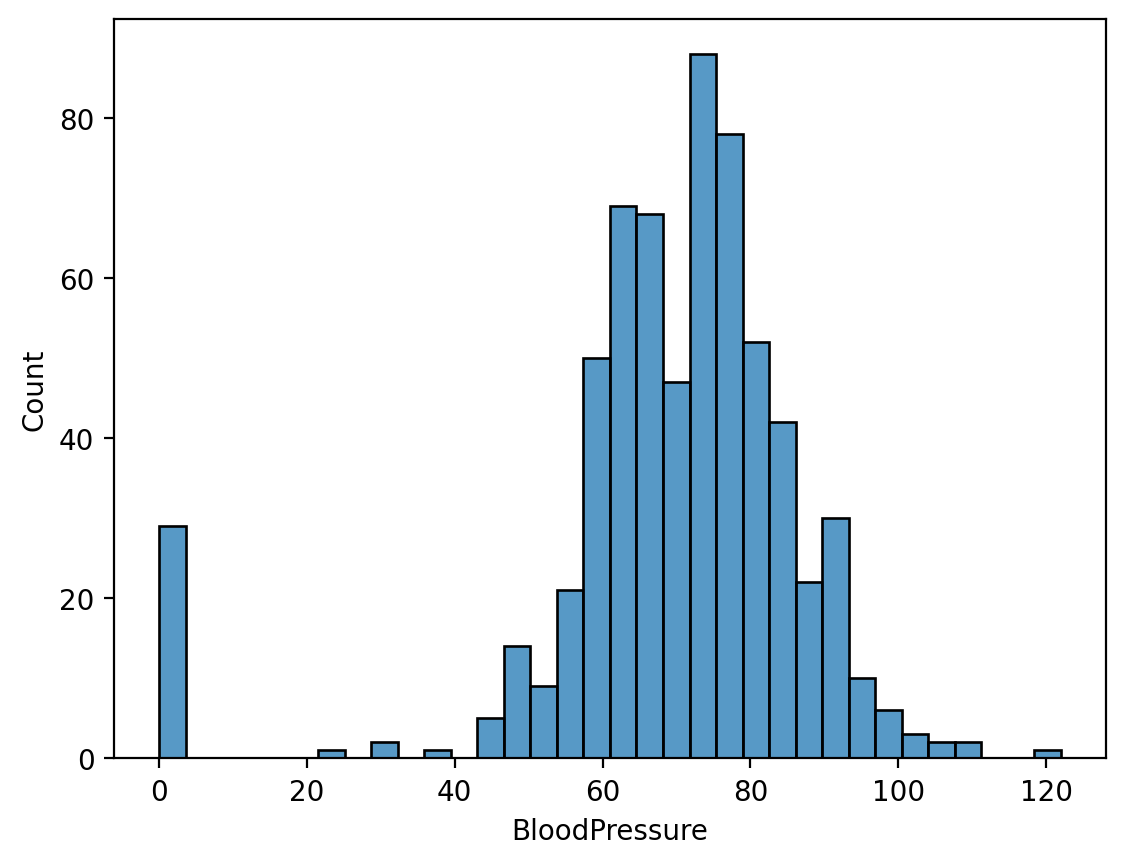

In [29]:
sns.histplot(X_train['BloodPressure']);

* 0という値がけっこうあるらしい。実は、これは欠測値。
* そこで、中央値で置き換えることにする。

imputation fill value for BloodPressure: 72.0


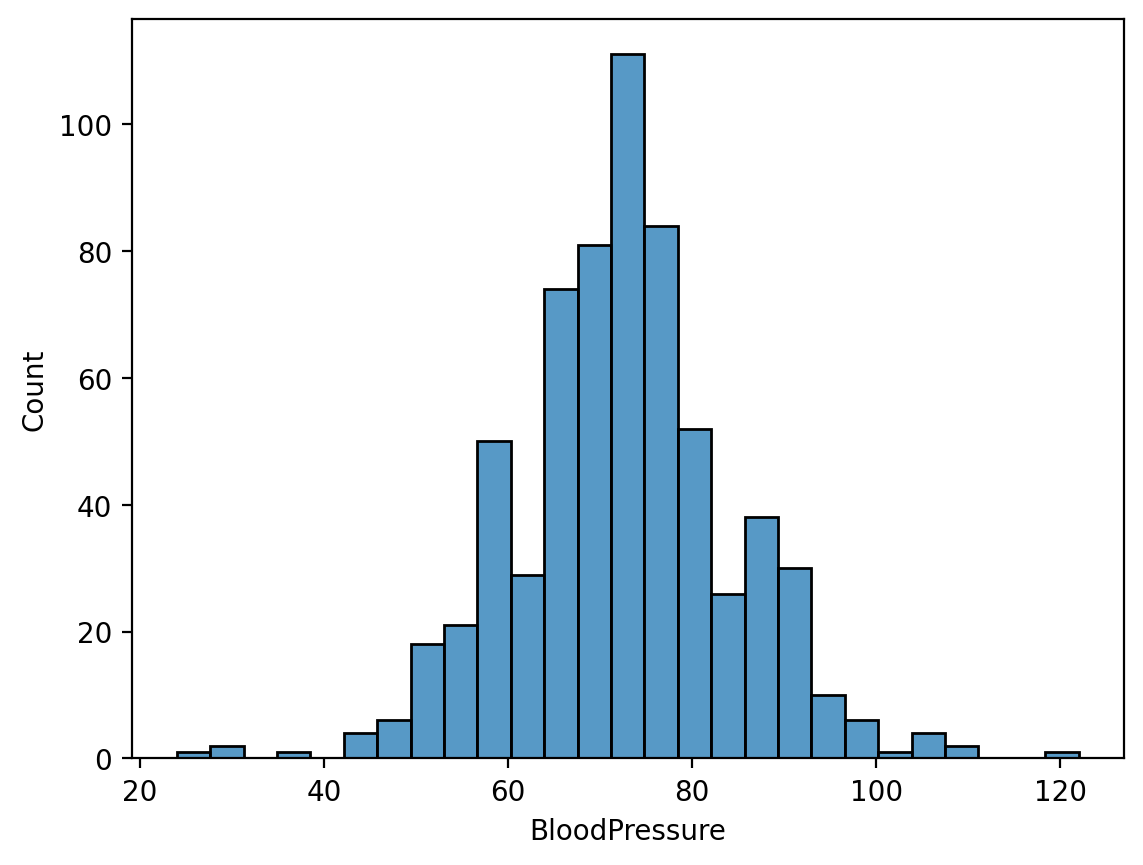

In [30]:
X_train_copy = X_train.copy()

feature = 'BloodPressure'
imp = SimpleImputer(missing_values=0, strategy='median')
X_train_copy[feature] = imp.fit_transform(X_train[[feature]])
print(f'imputation fill value for {feature}: {imp.statistics_[0]}')

sns.histplot(X_train_copy[feature]);

* 欠測箇所を中央値で埋める関数を定義しておく。
 * これは、交差検証を実行するときに使用する。

In [31]:
def preprocess(X_train, X_valid):
  imp = SimpleImputer(missing_values=0, strategy='median')

  X_train_copy, X_valid_copy = X_train.copy(), X_valid.copy()

  feature = 'BloodPressure'
  X_train_copy[feature] = imp.fit_transform(X_train[[feature]])
  X_valid_copy[feature] = imp.transform(X_valid[[feature]])
  print(f'  imputation fill value for {feature}: {imp.statistics_[0]}')

  return X_train_copy, X_valid_copy

* 交差検証で評価する。

In [32]:
cv(skf, X_train, y_train, preprocess=preprocess);

  imputation fill value for BloodPressure: 72.0
average precision: 0.7536
  imputation fill value for BloodPressure: 72.0
average precision: 0.8588
  imputation fill value for BloodPressure: 72.0
average precision: 0.7036
  imputation fill value for BloodPressure: 72.0
average precision: 0.5793
  imputation fill value for BloodPressure: 72.0
average precision: 0.7586
  imputation fill value for BloodPressure: 72.0
average precision: 0.8288
  imputation fill value for BloodPressure: 72.0
average precision: 0.5706
  imputation fill value for BloodPressure: 72.0
average precision: 0.6810
  imputation fill value for BloodPressure: 72.0
average precision: 0.7307
  imputation fill value for BloodPressure: 72.0
average precision: 0.6888
mean average precision: 0.7154


### BMIへの対応

* 次に、training dataの「BMI」のヒストグラムを描いてみる


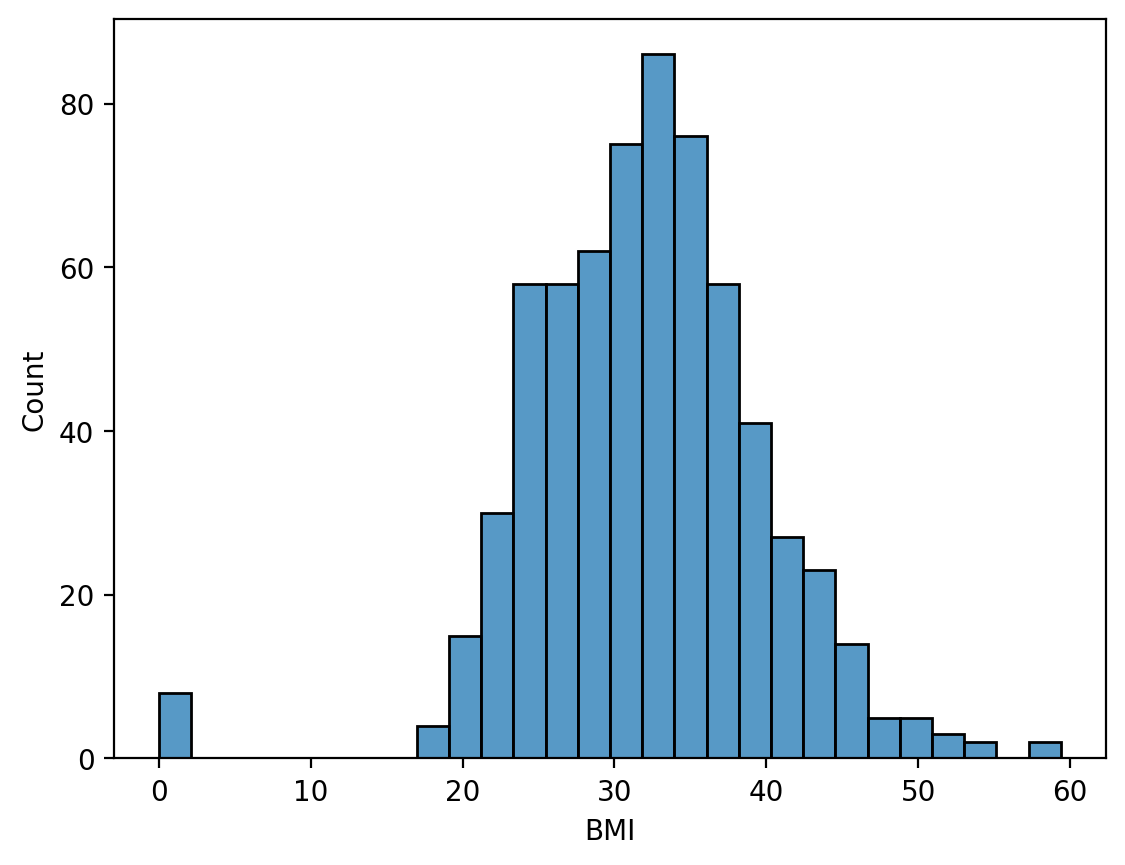

In [35]:
sns.histplot(X_train['BMI']);

* やはり欠測部分が0とされているようなので、先ほどと同様、中央値で埋める。


imputation fill value for BMI: 32.4


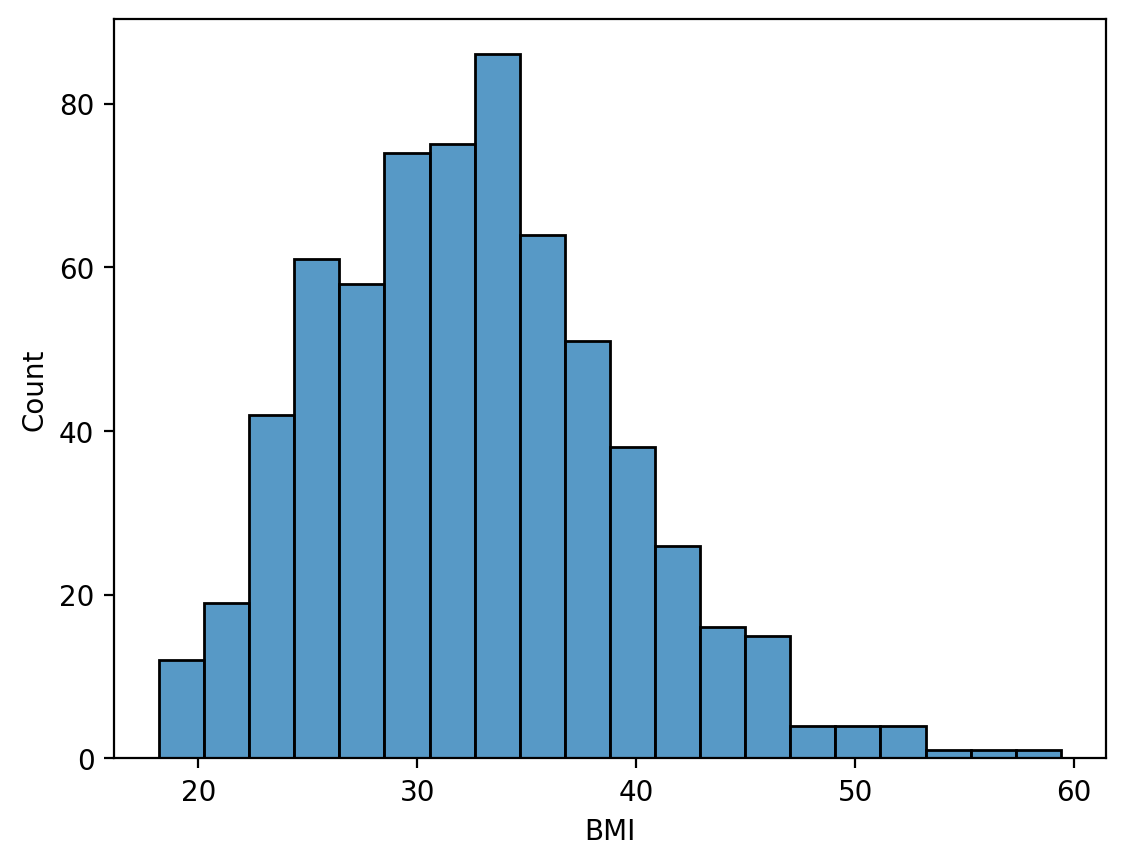

In [36]:
X_train_copy = X_train.copy()

feature = 'BMI'
imp = SimpleImputer(missing_values=0, strategy='median')
X_train_copy[feature] = imp.fit_transform(X_train[[feature]])
print(f'imputation fill value for {feature}: {imp.statistics_[0]}')

sns.histplot(X_train_copy[feature]);

* 交差検証で評価する。
 * 欠測箇所を埋める関数を書き換える。

In [37]:
def preprocess(X_train, X_valid):
  imp = SimpleImputer(missing_values=0, strategy='median')

  X_train_copy, X_valid_copy = X_train.copy(), X_valid.copy()

  for feature in ['BloodPressure', 'BMI']:
    X_train_copy[feature] = imp.fit_transform(X_train[[feature]])
    X_valid_copy[feature] = imp.transform(X_valid[[feature]])
    print(f'  imputation fill value for {feature}: {imp.statistics_[0]}')

  return X_train_copy, X_valid_copy

In [38]:
cv(skf, X_train, y_train, preprocess=preprocess);

  imputation fill value for BloodPressure: 72.0
  imputation fill value for BMI: 32.4
average precision: 0.7726
  imputation fill value for BloodPressure: 72.0
  imputation fill value for BMI: 32.4
average precision: 0.8583
  imputation fill value for BloodPressure: 72.0
  imputation fill value for BMI: 32.4
average precision: 0.7156
  imputation fill value for BloodPressure: 72.0
  imputation fill value for BMI: 32.1
average precision: 0.5745
  imputation fill value for BloodPressure: 72.0
  imputation fill value for BMI: 32.45
average precision: 0.7495
  imputation fill value for BloodPressure: 72.0
  imputation fill value for BMI: 32.4
average precision: 0.8296
  imputation fill value for BloodPressure: 72.0
  imputation fill value for BMI: 32.4
average precision: 0.5721
  imputation fill value for BloodPressure: 72.0
  imputation fill value for BMI: 32.3
average precision: 0.6846
  imputation fill value for BloodPressure: 72.0
  imputation fill value for BMI: 32.349999999999994
ave

### Glucoseへの対応

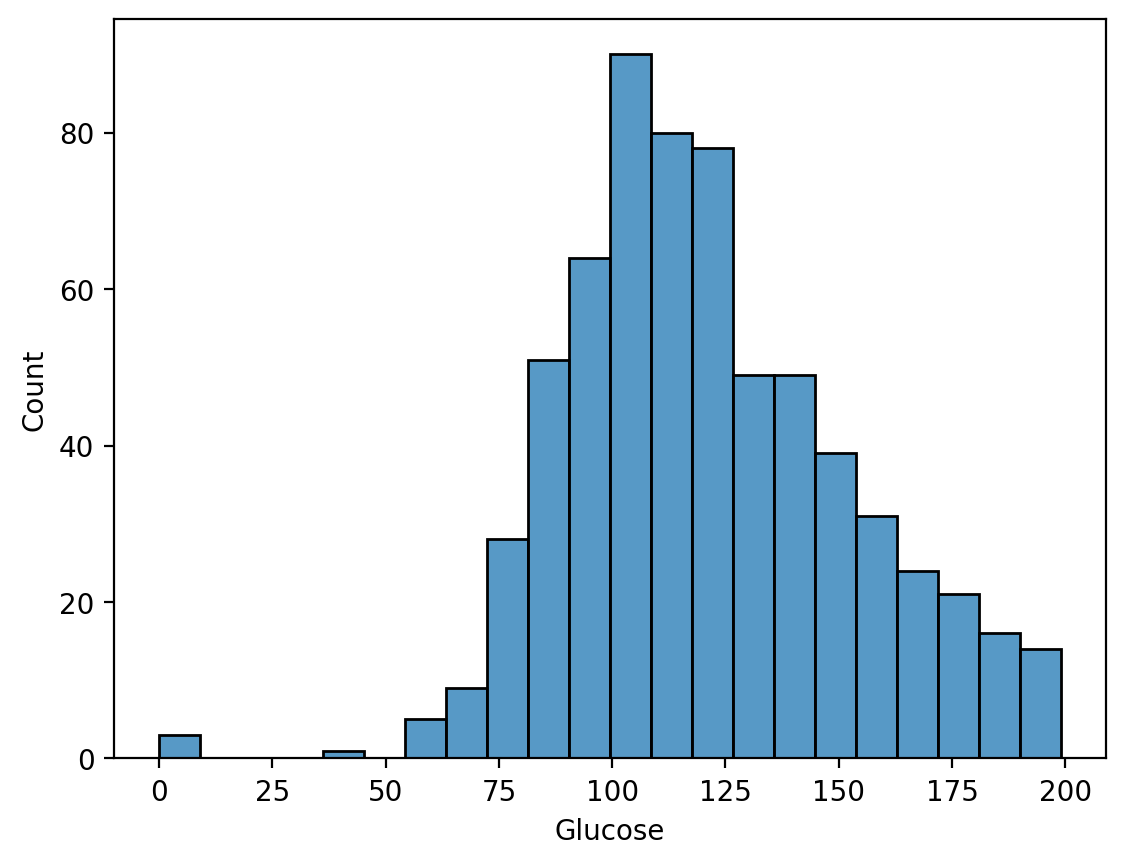

In [39]:
sns.histplot(X_train['Glucose']);

imputation fill value for Glucose: 117.0


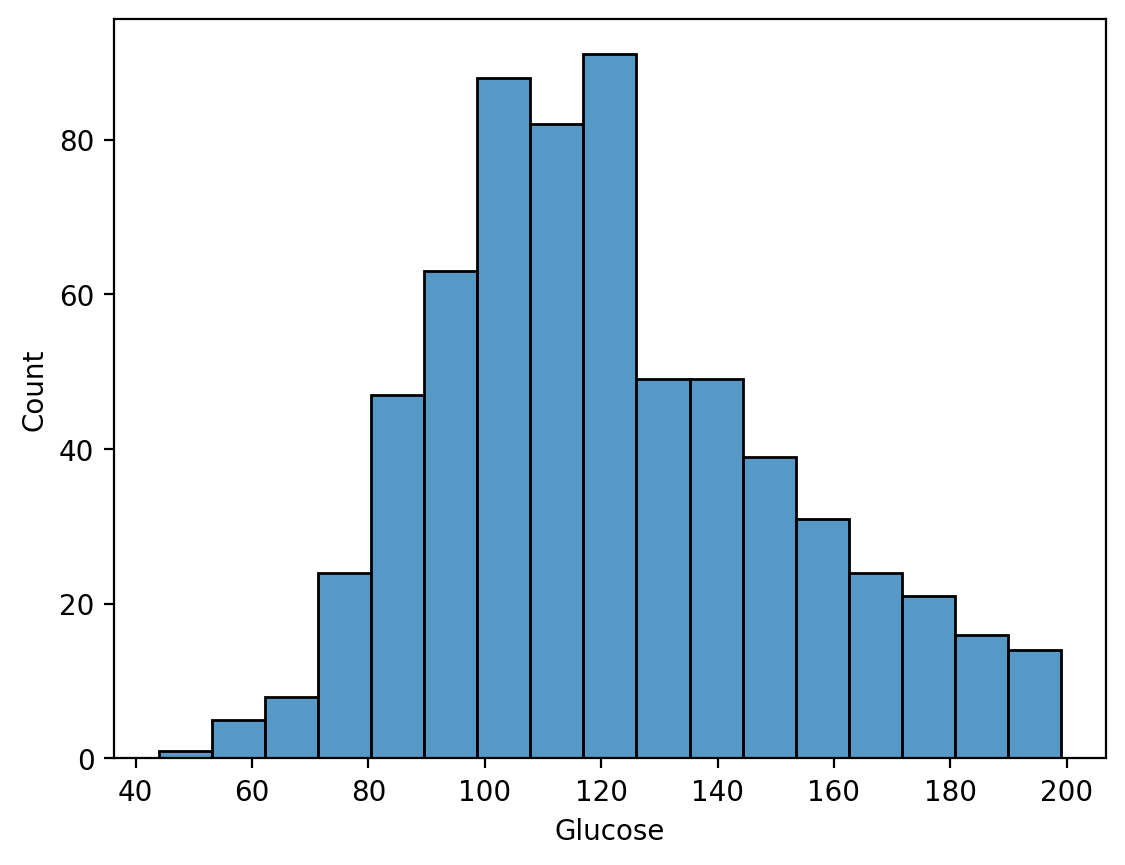

In [40]:
X_train_copy = X_train.copy()

feature = 'Glucose'
imp = SimpleImputer(missing_values=0, strategy='median')
X_train_copy[feature] = imp.fit_transform(X_train[[feature]])
print(f'imputation fill value for {feature}: {imp.statistics_[0]}')

sns.histplot(X_train_copy[feature]);

* 欠測箇所を埋める関数を書き換える。

In [41]:
def preprocess(X_train, X_valid):
  imp = SimpleImputer(missing_values=0, strategy='median')

  X_train_copy, X_valid_copy = X_train.copy(), X_valid.copy()

  for feature in ['BloodPressure', 'BMI', 'Glucose']:
    X_train_copy[feature] = imp.fit_transform(X_train[[feature]])
    X_valid_copy[feature] = imp.transform(X_valid[[feature]])
    print(f'imputation fill value for {feature}: {imp.statistics_[0]}')

  return X_train_copy, X_valid_copy

In [42]:
cv(skf, X_train, y_train, preprocess=preprocess);

imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.0
average precision: 0.7768
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.0
average precision: 0.8628
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.5
average precision: 0.7155
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.1
imputation fill value for Glucose: 117.0
average precision: 0.5734
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.45
imputation fill value for Glucose: 117.5
average precision: 0.7555
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 116.0
average precision: 0.8317
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value f

* ここまでベストな結果は？

### SkinThicknessとInsulinへの対応

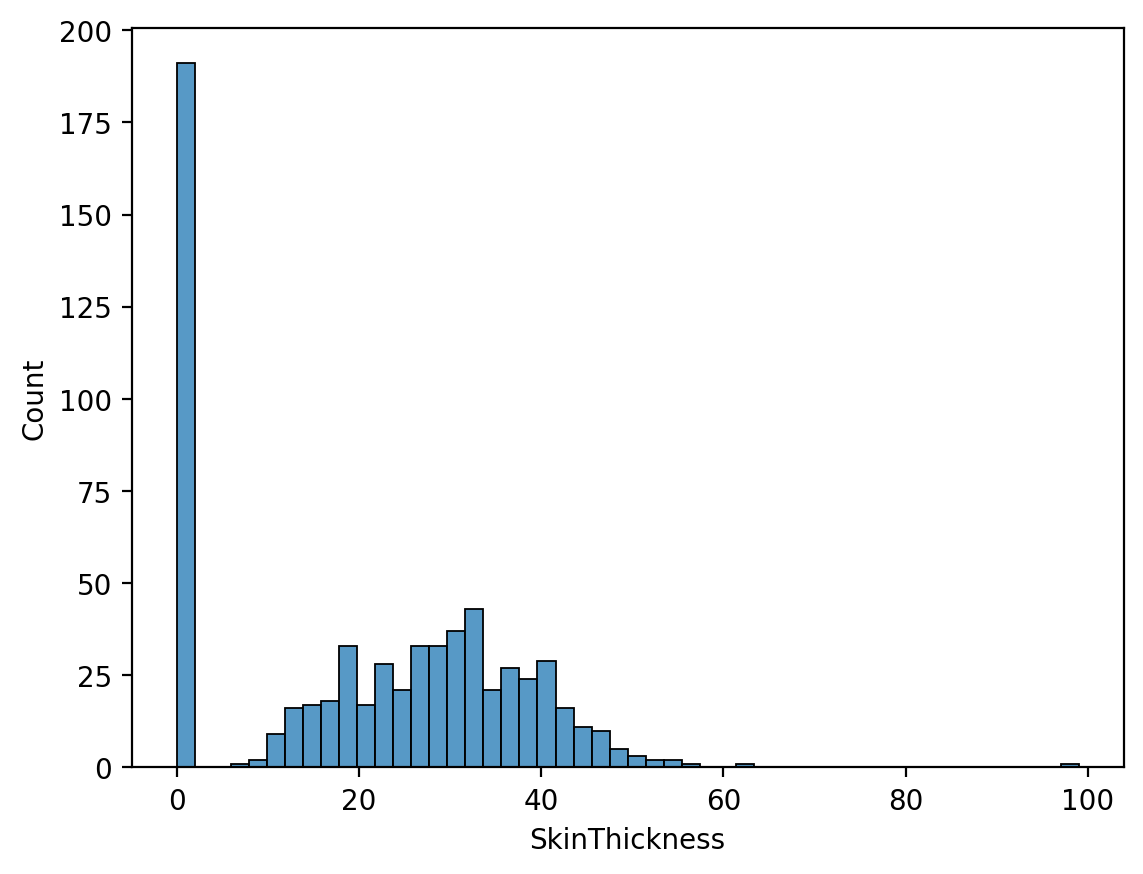

In [43]:
sns.histplot(X_train['SkinThickness'], bins=50);

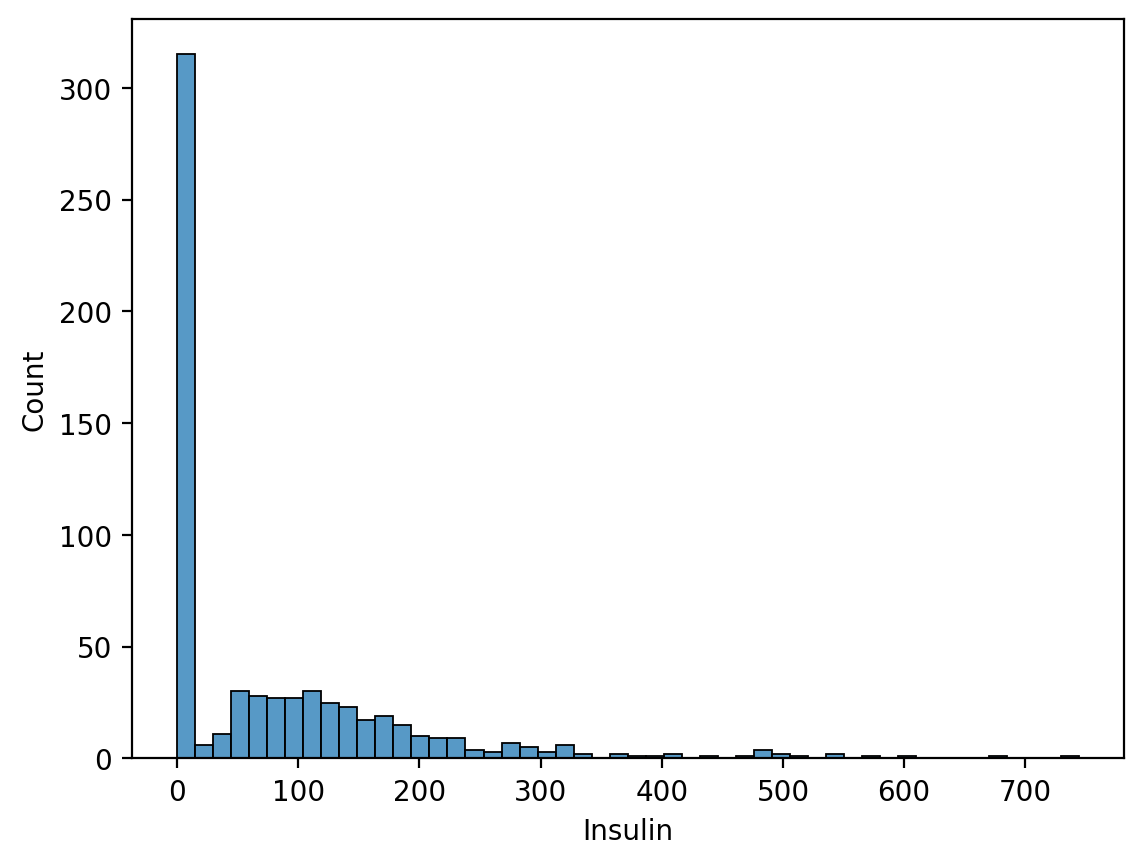

In [44]:
sns.histplot(X_train['Insulin'], bins=50);

In [45]:
(X_train['SkinThickness'] == 0).sum()

np.int64(191)

In [46]:
(X_train['Insulin'] == 0).sum()

np.int64(314)

* 欠測値が多すぎるので、同じ一つの値で埋めると、問題あり。

In [47]:
((X_train['SkinThickness'] == 0) & (X_train['Insulin'] == 0)).sum()

np.int64(191)

In [48]:
for i in X_train.index[X_train['SkinThickness'] == 0]:
  if not i in X_train.index[X_train['Insulin'] == 0]:
    print('No')

* SkinThicknessが0の個体は、必ずInsulinも0になっているらしい。

 * ただし、これは訓練データだけでこうなっているだけかもしれないので、この事実に依存して何かをすることはしない。

* 線形回帰でSkinThicknessとInsulinの欠測部分を埋める。
 * 欠測部分を同じ値で埋めたくないため。

* まず、前に使った前処理の関数を別の名前で定義しておく。

In [49]:
def preprocess_0(X_train, X_valid):
  imp = SimpleImputer(missing_values=0, strategy='median')

  X_train_copy, X_valid_copy = X_train.copy(), X_valid.copy()

  for feature in ['BloodPressure', 'BMI', 'Glucose']:
    X_train_copy[feature] = imp.fit_transform(X_train[[feature]])
    X_valid_copy[feature] = imp.transform(X_valid[[feature]])
    print(f'imputation fill value for {feature}: {imp.statistics_[0]}')

  return X_train_copy, X_valid_copy

* そして、新たに前処理の関数を定義する。
 * この関数の中で、前に使った前処理を定義した関数を呼び出すことにする。

In [58]:
def preprocess(X_train, X_valid):

  # 前に使った前処理を定義した関数を呼び出す
  X_train_copy, X_valid_copy = preprocess_0(X_train, X_valid)

  # 欠測値を埋めるための回帰において特徴量として使う列
  columns = X_train.columns.drop('SkinThickness').drop('Insulin')

  # 線形回帰で欠測箇所を埋める
  for feature in ['SkinThickness', 'Insulin']:
    reg = LinearRegression()
    indices = (X_train[feature] != 0)
    reg.fit(X_train.loc[indices, columns], X_train.loc[indices, feature])
    prediction = reg.predict(X_train.loc[~ indices, columns]).astype(np.int64)
    X_train_copy.loc[~ indices, feature] = prediction

    indices = (X_valid[feature] != 0)
    prediction = reg.predict(X_valid.loc[~ indices, columns]).astype(np.int64)
    X_valid_copy.loc[~ indices, feature] = prediction

  return X_train_copy, X_valid_copy

In [59]:
cv(skf, X_train, y_train, preprocess=preprocess);

imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.0
average precision: 0.7543
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.0
average precision: 0.8611
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.5
average precision: 0.6904
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.1
imputation fill value for Glucose: 117.0
average precision: 0.5647
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.45
imputation fill value for Glucose: 117.5
average precision: 0.7621
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 116.0
average precision: 0.8210
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value f

* 次は、k-NNを使って欠測値を埋める。

In [60]:
# kは、関数の外で値を指定する。

def preprocess(X_train, X_valid):
  # 前に行った前処理を定義した関数を呼び出す
  X_train_copy, X_valid_copy = preprocess_0(X_train, X_valid)

  # 欠測値を埋めるための回帰において特徴量として使う列
  columns = X_train.columns.drop('SkinThickness').drop('Insulin')

  print(f'imputation k-NN k={k}')
  for feature in ['SkinThickness', 'Insulin']:
    reg = KNeighborsRegressor(n_neighbors=k)
    indices = (X_train[feature] != 0)
    reg.fit(X_train.loc[indices, columns], X_train.loc[indices, feature])
    prediction = reg.predict(X_train.loc[~ indices, columns]).astype(np.int64)
    X_train_copy.loc[~ indices, feature] = prediction

    indices = (X_valid[feature] != 0)
    prediction = reg.predict(X_valid.loc[~ indices, columns]).astype(np.int64)
    X_valid_copy.loc[~ indices, feature] = prediction

  return X_train_copy, X_valid_copy

In [61]:
best_k, best_score = 1, 0.0

for k in range(1, 21):
  score = cv(skf, X_train, y_train, preprocess=preprocess)
  print('-'*64)
  if best_score < score:
    best_k, best_score = k, score

print(f'best score {best_score:.4f} for k = {best_k}')

imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.0
imputation k-NN k=1
average precision: 0.7713
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.0
imputation k-NN k=1
average precision: 0.8585
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.5
imputation k-NN k=1
average precision: 0.7193
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.1
imputation fill value for Glucose: 117.0
imputation k-NN k=1
average precision: 0.5871
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.45
imputation fill value for Glucose: 117.5
imputation k-NN k=1
average precision: 0.7634
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 116.0
imputation k-NN k=1
average pre

### スケーラー

* k-NNで欠測箇所を埋める関数を別の名前で定義する。

In [62]:
# best_kは、上で値を設定したグローバル変数。

def preprocess_1(X_train, X_valid):
  # 前に行った前処理を定義した関数を呼び出す
  X_train_copy, X_valid_copy = preprocess_0(X_train, X_valid)

  # 欠測値を埋めるための回帰において特徴量として使う列
  columns = X_train.columns.drop('SkinThickness').drop('Insulin')

  k = best_k
  print(f'imputation k-NN k={k}')
  for feature in ['SkinThickness', 'Insulin']:
    reg = KNeighborsRegressor(n_neighbors=k)
    indices = (X_train[feature] != 0)
    reg.fit(X_train.loc[indices, columns], X_train.loc[indices, feature])
    prediction = reg.predict(X_train.loc[~ indices, columns]).astype(np.int64)
    X_train_copy.loc[~ indices, feature] = prediction

    indices = (X_valid[feature] != 0)
    prediction = reg.predict(X_valid.loc[~ indices, columns]).astype(np.int64)
    X_valid_copy.loc[~ indices, feature] = prediction

  return X_train_copy, X_valid_copy

* スケーリングを行う関数の中で、上の関数を呼び出す。

In [63]:
def preprocess(X_train, X_valid):
  X_train_copy, X_valid_copy = preprocess_1(X_train, X_valid)
  scaler = MinMaxScaler()
  scaler.fit(X_train_copy)
  return scaler.transform(X_train_copy), scaler.transform(X_valid_copy)

In [64]:
cv(skf, X_train, y_train, preprocess=preprocess);

imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.0
imputation k-NN k=1
average precision: 0.7564
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.0
imputation k-NN k=1
average precision: 0.8604
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.5
imputation k-NN k=1
average precision: 0.7181
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.1
imputation fill value for Glucose: 117.0
imputation k-NN k=1
average precision: 0.5526
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.45
imputation fill value for Glucose: 117.5
imputation k-NN k=1
average precision: 0.7628
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 116.0
imputation k-NN k=1
average pre

In [65]:
def preprocess(X_train, X_valid):
  X_train_copy, X_valid_copy = preprocess_1(X_train, X_valid)
  scaler = StandardScaler()
  scaler.fit(X_train_copy)
  return scaler.transform(X_train_copy), scaler.transform(X_valid_copy)

In [66]:
cv(skf, X_train, y_train, preprocess=preprocess);

imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.0
imputation k-NN k=1
average precision: 0.7702
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.0
imputation k-NN k=1
average precision: 0.8609
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.5
imputation k-NN k=1
average precision: 0.7214
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.1
imputation fill value for Glucose: 117.0
imputation k-NN k=1
average precision: 0.5881
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.45
imputation fill value for Glucose: 117.5
imputation k-NN k=1
average precision: 0.7620
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 116.0
imputation k-NN k=1
average pre

### 正則化

In [67]:
best_C, best_score = 0, 0

for C in np.power(10.0, np.arange(13) - 5):
  score = cv(skf, X_train, y_train, preprocess=preprocess_1, C=C)
  if best_score < score:
    best_C, best_score = C, score
  print('-' * 64)

print(f'best score {best_score:.4f} for C={best_C}')

C = 1e-05
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.0
imputation k-NN k=1
average precision: 0.7182
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.0
imputation k-NN k=1
average precision: 0.8261
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.5
imputation k-NN k=1
average precision: 0.6541
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.1
imputation fill value for Glucose: 117.0
imputation k-NN k=1
average precision: 0.4472
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.45
imputation fill value for Glucose: 117.5
imputation k-NN k=1
average precision: 0.7210
imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 116.0
imputation k-NN k=1
a

* 以上をまとめると・・・
 * 'BloodPressure', 'BMI', 'Glucose'の欠損値は中央値で埋める。
 * 'SkinThickness', 'Insulin'の欠損値はk-NNで埋める。
 * ロジスティック回帰はパラメータ`C=0.1`で正則化して使う。

## テストデータで最終評価

* 訓練データの中央値を使って、テストデータの欠測値を埋める。

In [68]:
# 訓練データについては、最初に取っておいたオリジナル X_train_original を使う。

X_train_copy = X_train_original.copy()
X_test_copy = X_test.copy()

for feature in ['BloodPressure', 'BMI', 'Glucose']:
  imp = SimpleImputer(missing_values=0, strategy='median')
  X_train_copy[feature] = imp.fit_transform(X_train_original[[feature]])
  X_test_copy[feature] = imp.transform(X_test[[feature]])
  print(f'imputation fill value for {feature}: {imp.statistics_[0]}')

imputation fill value for BloodPressure: 72.0
imputation fill value for BMI: 32.4
imputation fill value for Glucose: 117.0


* ちゃんと動いたので、上書き。

In [69]:
X_train = X_train_copy
X_test = X_test_copy

* k-NNでは、上で'BloodPressure', 'BMI', 'Glucose'の欠測値を埋めたデータを使う。

In [71]:
# 欠測値を埋めるために特徴量として使う列
columns = X_train.columns.drop('SkinThickness').drop('Insulin')

k = best_k

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

for feature in ['SkinThickness', 'Insulin']:
  reg = KNeighborsRegressor(n_neighbors=k)
  indices = (X_train[feature] != 0)
  reg.fit(X_train.loc[indices, columns], X_train.loc[indices, feature])
  prediction = reg.predict(X_train.loc[~ indices, columns]).astype(np.int64)
  X_train_copy.loc[~ indices, feature] = prediction
  indices = (X_test[feature] != 0)
  prediction = reg.predict(X_test.loc[~ indices, columns]).astype(np.int64)
  X_test_copy.loc[~ indices, feature] = prediction

* ちゃんと動いたので上書き。

In [72]:
X_train = X_train_copy
X_test = X_test_copy

In [73]:
model = LogisticRegression(max_iter=1000, C=0.1, random_state=123)
model.fit(X_train, y_train)
print('test score: {:.4f}'.format(model.score(X_test, y_test)))

test score: 0.7759


In [74]:
y_test_pred_proba = model.predict_proba(X_test)
print('ROC AUC: {:.4f}'.format(roc_auc_score(y_test, y_test_pred_proba[:,1])))

ROC AUC: 0.8671


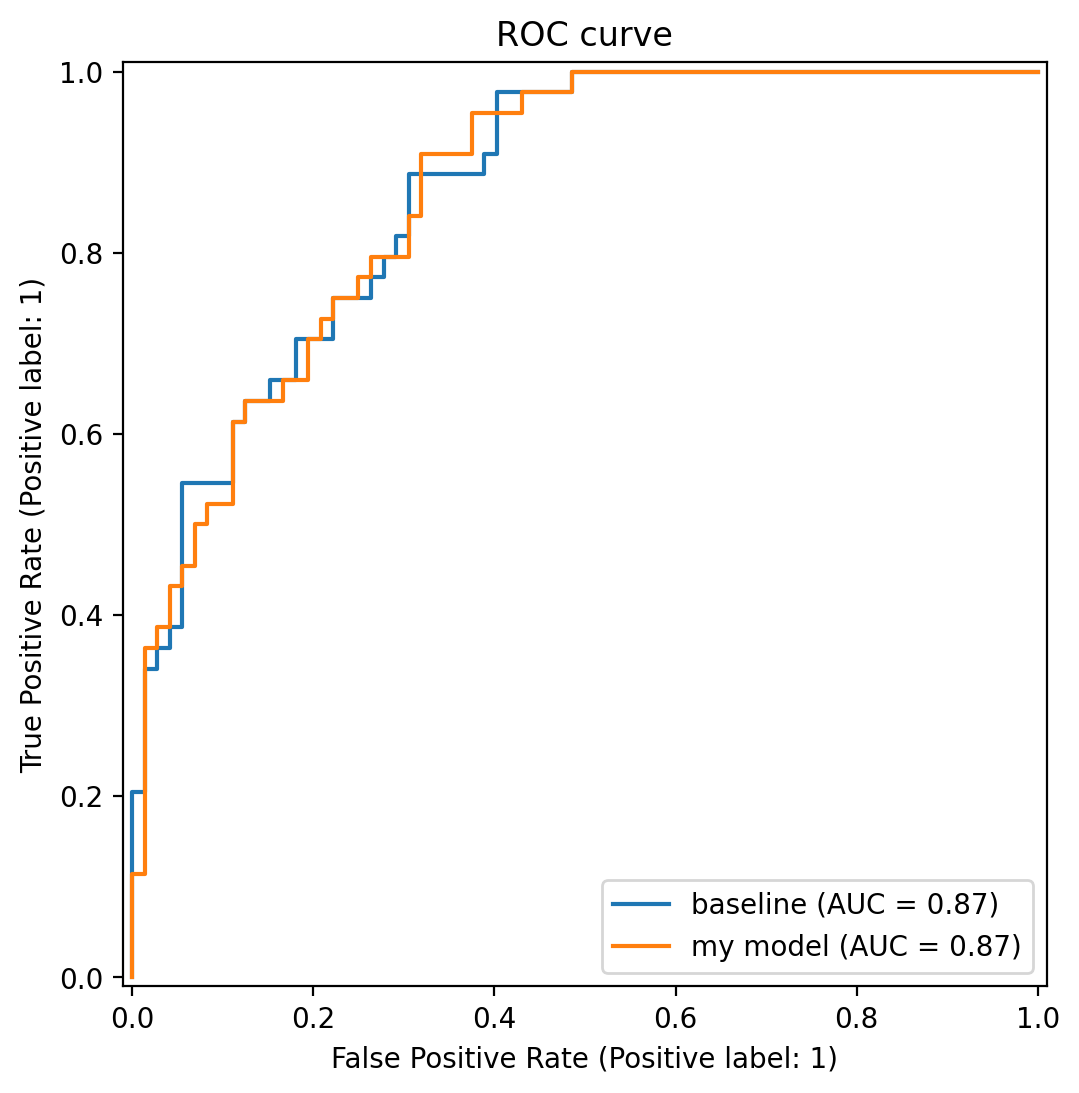

In [76]:
fig, ax = plt.subplots(figsize=(6, 6))
RocCurveDisplay.from_estimator(baseline, X_test, y_test, name="baseline", ax=ax)
display = RocCurveDisplay.from_estimator(model, X_test, y_test, name="my model", ax=ax)
_ = display.ax_.set_title("ROC curve")

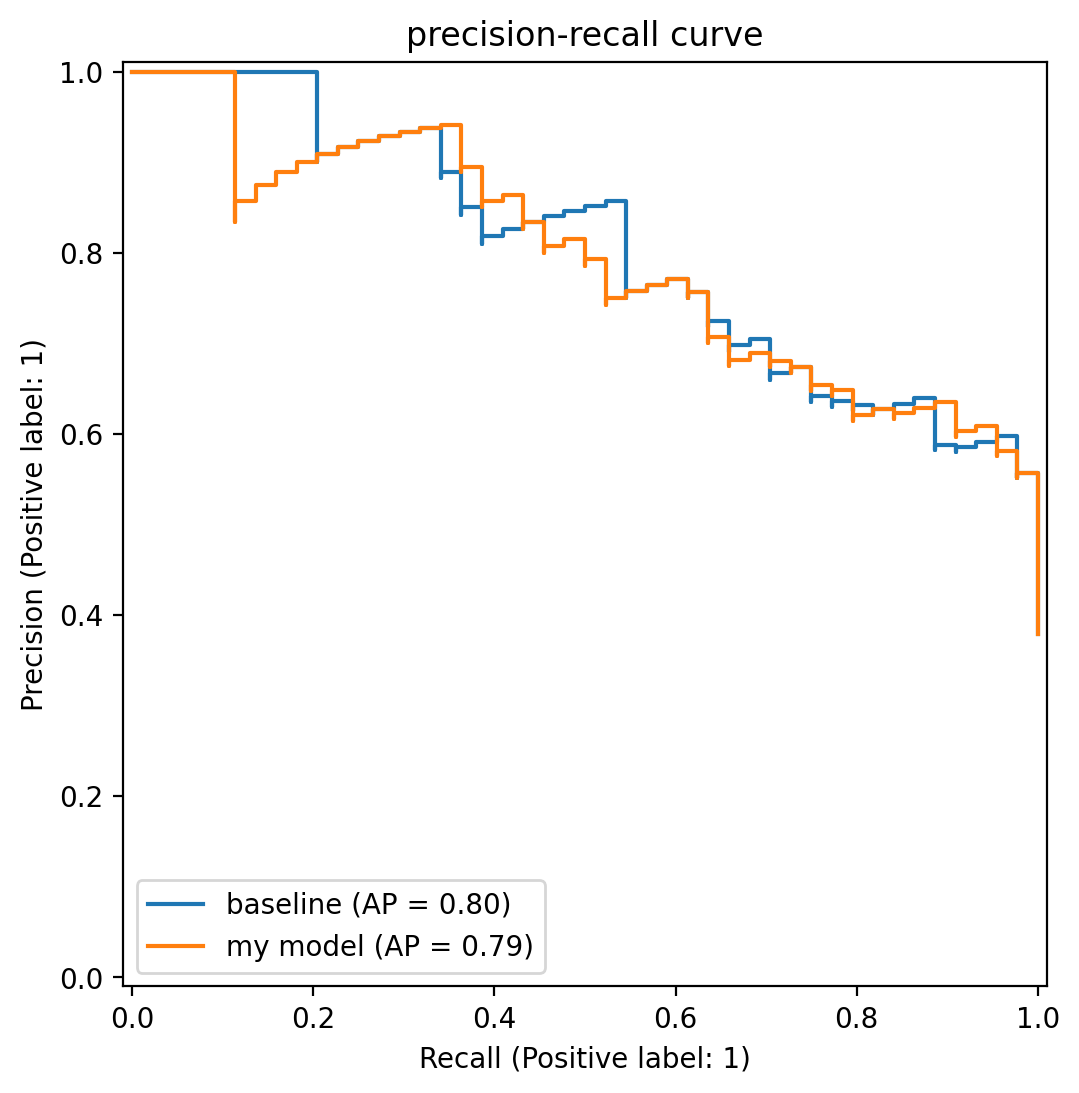

In [77]:
fig, ax = plt.subplots(figsize=(6, 6))
PrecisionRecallDisplay.from_estimator(baseline, X_test, y_test, name="baseline", ax=ax)
display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="my model", ax=ax)
_ = display.ax_.set_title("precision-recall curve")

In [78]:
average_precision = average_precision_score(y_test, y_test_pred_proba[:,1])
print(f'average precision: {average_precision:.4f}')

average precision: 0.7930





---



# プランナー課題８
* 上の結果を改良できるかどうか、試行錯誤してみてください。
* training setとtest setへの分割は、変更しないでください。
* training set上での試行錯誤は、どんな方法を使ってもいいです。
  * test setは、最終的な性能評価のときに一回使うだけです。